In [27]:
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import os 

k_colors = ['rgb(0,127,206)','rgb(62,196,4)','rgb(255,125,16)','rgb(253,99,90)']#blue,gree,orange,red
plotly_themes = ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]#plotly_white plotly_dark
theme = plotly_themes[1]


In [3]:
#path to data files
notebook_path = os.getcwd()
project_path = notebook_path[0:len(notebook_path)-16]+"data/"

In [4]:
movies = pd.read_csv(project_path+'movie.csv')
movies["year"] = movies["title"].str.extract('(\(\d\d\d\d\))',expand=False) #everything with parentheis and numbers (1995)
movies['year'] = movies["year"].str.extract('(\d\d\d\d)',expand=False) #only numbers
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')#replace numbers and parenthesis
movies['title'] = movies['title'].apply(lambda x: x.strip())
movies.head(5)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [5]:
tags = pd.read_csv(project_path+'tag.csv')
tags.head(5)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [6]:
ratings = pd.read_csv(project_path+'rating.csv')
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [9]:
tags.shape

(465564, 4)

In [10]:
ratings.shape

(20000263, 4)

In [11]:
tags.userId.nunique()

7801

In [12]:
tags.movieId.nunique()

19545

* There are 465,564 not unique tags given by users in different periods of time; by contrast of only 7,801 unique users that give a tag to a movie
* 19,545 movies were tag amount 27,278 of all the movies

In [13]:
print("Min time of the tags:"  + str(min(tags.timestamp))+"\nMax time of the tags: "+max(tags.timestamp)+
"\nMin time of the ratings: "+min(ratings.timestamp)+
"\nMax time of the ratings: "+max(ratings.timestamp))

Min time of the tags:2005-12-24 13:00:10
Max time of the tags: 2015-03-31 03:09:12
Min time of the ratings: 1995-01-09 11:46:44
Max time of the ratings: 2015-03-31 06:40:02


For time purpose, the last 2 years of the dataset are going to be analyze.

In [14]:
ratings = ratings.loc[ratings.timestamp>'2013-01-01']
tags = tags.loc[tags.timestamp>'2013-01-01']

tags.to_csv("../../data/tag_filtered.csv",index = False)
ratings.to_csv("../../data/ratings_filtered.csv",index = False)


Lets see the most common tags:

In [15]:
tags_grouped = tags.groupby(["movieId","tag"]).agg({"userId":"count"})\
.rename(columns={'userId':'count'})\
    .reset_index()\
    .sort_values("count",ascending  = False)
tags_grouped.head(5)

,movieId,tag,count
22175,4878,original,61
13384,2420,mentor,54
14982,2762,great ending,51
10006,1704,mentor,49
12654,2291,original,49


original and mentor seem to have spaces that makes them as unique tags so it is necesary to clean those tags

## Cleaning the tags

In [16]:
#if not installed, nltk.download(). look for corpora>stopwords, packages>wordnet
try:
    stop_words = set(stopwords.words("english")) 
except LookupError:
    import nltk
    nltk.download()

In [17]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)#only alfanumeric and spaces
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text] # meeting > meet, was > be
    text = [word for word in text if not word in stop_words] #exclude stop words
    text = " ".join(text)
    return text

tags_grouped['processed_tag'] = tags_grouped.tag.apply(lambda x: clean_text(x))

In [18]:
tags_grouped.tail()

,movieId,tag,count,processed_tag
30126,8265,animals,1,animal
30127,8265,boring,1,bore
30128,8265,eco-horror,1,ecohorror
30129,8265,enviromental message,1,enviromental message
77033,131258,whale,1,whale


## Distribution of number of tags in movies given by users

Lets see the top movies with most tags in the last 2 years

In [19]:
movies_tag_grouped = (tags_grouped.groupby(['movieId'])
      .agg({'processed_tag': lambda x: x.tolist()})
      .reset_index())

movies_tag_grouped["n_tags"] = movies_tag_grouped.processed_tag.apply(lambda x : len(x))

movies_tag_grouped.head()

,movieId,processed_tag,n_tags
0,1,"[pixar, animation, comedy, child, disney, frie...",17
1,2,"[time travel, robin williams, magic board game...",12
2,3,"[no_fa_ganes, sequel]",2
3,4,"[clv, character, chick flick]",3
4,5,"[clv, comedy, touch]",3


In [21]:
df = px.data.tips()
fig = px.box(movies_tag_grouped, y="n_tags",
labels={'n_tags':'Number of tags'},
template=theme)
fig.update_traces(marker_color=k_colors[0])
fig.show()

Just by curiosity, lets see wich are the movies that have a lot of tags:

In [22]:
movies_tag_grouped_with_name = movies.merge(movies_tag_grouped,"right")

In [23]:
movies_tag_grouped_with_name.loc[movies_tag_grouped.n_tags>80].sort_values("n_tags",ascending=False)

,movieId,title,genres,year,processed_tag,n_tags
190,296,Pulp Fiction,Comedy|Crime|Drama|Thriller,1994,"[quentin tarantino, quentin tarantino, dark co...",201
232,356,Forrest Gump,Comedy|Drama|Romance|War,1994,"[tom hank, bittersweet, inspirational, tom han...",145
379,593,"Silence of the Lambs, The",Crime|Horror|Thriller,1991,"[serial killer, excellent script, great act, p...",102
10334,99114,Django Unchained,Action|Drama|Western,2012,"[quentin tarantino, leonardo dicaprio, samuel ...",95
10179,97752,Cloud Atlas,Drama|Sci-Fi|IMAX,2012,"[multiple storyline, visually appeal, dystopia...",91
10208,97938,Life of Pi,Adventure|Drama|IMAX,2012,"[visually appeal, cinematography, religion, gr...",90
12114,109487,Interstellar,Sci-Fi|IMAX,2014,"[christopher nolan, space, matthew mcconaughey...",90
10294,98809,"Hobbit: An Unexpected Journey, The",Adventure|Fantasy|IMAX,2012,"[beautiful scenery, adventure, fantasy, peter ...",89
10802,102125,Iron Man 3,Action|Sci-Fi|Thriller|IMAX,2013,"[robert downey jr, superhero, marvel, ben king...",89
8405,79132,Inception,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,2010,"[alternate reality, thoughtprovoking, visually...",84


And visualize with a cloudword the most used tags:

(-0.5, 799.5, 599.5, -0.5)

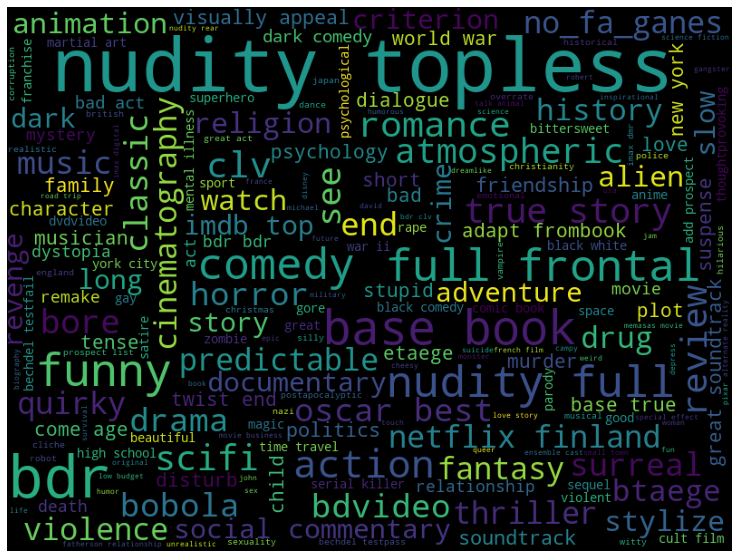

In [28]:

cloud=WordCloud(width=800, height=600).generate(" ".join(tags_grouped['processed_tag'])) 
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

And see the top 10 tags used:

In [31]:
tags_names_grouped = tags_grouped.groupby(["processed_tag"])\
.agg({"movieId":"count"})\
.rename({'movieId' : 'count'},axis=1)\
.reset_index()\
.sort_values("count",ascending=False)
tags_names_grouped.head(10)

,processed_tag,count
1536,bdr,1409
10024,nudity topless,1399
2894,clv,575
1490,base book,527
5277,funny,443
10018,nudity full frontal,416
2954,comedy,385
11612,review,357
237,action,339
1538,bdvideo,301


In [ ]:
Lets view the count 

In [39]:
tags["year_month"] = pd.DatetimeIndex(tags['timestamp']).year*100+\
pd.DatetimeIndex(tags['timestamp']).month
top_10_tags_names=list(tags_names_grouped.head(10)["processed_tag"])
tags['processed_tag'] = tags.tag.apply(lambda x: clean_text(x))
tags_filtered_top_names = tags[tags['processed_tag'].isin(top_10_tags_names)]
tags_filtered_top_names_agg = tags_filtered_top_names.groupby(["processed_tag","year_month"]).agg(count = ("movieId","count")).reset_index()

In [40]:
tags_filtered_top_names_agg['year_month'] = tags_filtered_top_names_agg.year_month.astype(str)
fig = px.line(tags_filtered_top_names_agg, x="year_month", y="count", color="processed_tag",
              line_group="processed_tag", hover_name="processed_tag",template=theme)
fig.show()

It seems that in june of 2014 a lot of users used nudity topless as a tag for movies. Lets see if one movie was tag by a lot of users:

In [42]:
tags_201405 = tags[(tags["timestamp"]>='2014-05-01') &(tags["timestamp"]<'2014-06-01')]

tags_201405[tags_201405.processed_tag=="nudity topless"].merge(movies.loc[:,~movies.columns.isin(["year"])])\
    .groupby(["movieId","title"]).agg(count=("movieId","count"))\
    .reset_index()\
    .sort_values("count",ascending=False)\
        .head(10)

,movieId,title,count
370,7419,After Hours,2
537,52973,Knocked Up,2
84,1674,Witness,2
460,33903,"Edukators, The (Die Fetten Jahre sind vorbei)",2
128,2467,"Name of the Rose, The (Name der Rose, Der)",2
95,1844,Live Flesh (Carne trémula),2
604,65642,"Timecrimes (Cronocrímenes, Los)",2
839,109673,300: Rise of an Empire,2
564,58743,Alatriste,1
557,56336,Wrong Turn 2: Dead End,1


It is strange that a lot of of movies were tag in that period of time. Maybe there was a movement that was aggainst nudity in movies